## Autoencoders Lab
#### visualizing HapMap phase 3 populations

**This is a solution template. Every chunk of code requiring your input will begin with the # TASK comment and all places where you should fill-in with your code are marked by ellipsis (...).**

---

In this lab, we will use chip genotyping data from the HapMap project (phase 3). These data come from a number of humans belonging to different ethnic groups/populations. The groups are genetically distinct but, in some cases, closely related and thus somewhat difficult to distinguish. We will first try to visualize population structure using classical dimensionality reduction techniques (PCA, MDS). Next, we will build autoencoder and see if it does any different in separating different populations. Throughout the lab, we will use keras interface to TensorFlow.

---

### Background
The purpose of this lab is to evaluate the possibility of using autoencoder as a replacement/complement to more “classical” linear dimensionality reduction methods such as PCA or MDS. These are commonly used for, e.g. visualizing population structure in genetics. One of the main motivations is that when inferring genomic kinship from a large number of markers M (large enough to capture population structure at fine level), one necessarily introduces correlations between variables, here, genetic markers. This is predominantly due to the linkage disequilibrium, but also due to the large M that, even by pure chance, introduces correlated variables to the data. This correlation structure introduces non-linearity that, in turn, makes the data not very well suitable for PCA/MDS since both approaches rely on computing kinship matrix determinants that, for a lot of highly correlated variables, become 0 and prevent us from computing exact solutions (division by zero is undefined).

### Data

Here, the working hypotheses is that by choosing non-linear activation functions, e.g. ReLU, one can circumvent this problem and use autoencoder approach to reduce the dimensionality by embedding kinship data in a low dimensional latent representation space that, in turn, can easily be visualized. The idea emerged during the EMBL conference Reconstructing the Human Past, Heidelberg 🍺, April 2019, in a number of discussions with Nikolay Oskolkov 👨‍🔬 and other conference participants: 🐿, 🦓 and 🐉.

Data comes from the HapMap phase 3 project. Here, for computational feasibility, we will be using smaller dataset. I have pre-selected 5,000 autosomal markers with call rate of 100%. We will not be dealing with missing data here although autoencoders, in contrast to PCA and MDS, can.

HapMap 3 populations:

* ASW – African 🌍 ancestry in Southwest USA 🇺🇸
* CEU – Utah residents with Northern and Western European 🌍 ancestry from the CEPH collection
* CHB – Han Chinese in Beijing, China 🇨🇳
* CHD – Chinese 🇨🇳 in Metropolitan Denver, Colorado ⛰
* GIH – Gujarati Indians 🇮🇳 in Houston, Texas
* JPT – Japanese in Tokyo, Japan 🇯🇵
* LWK – Luhya in Webuye, Kenya 🇰🇪
* MEX – Mexican 🇲🇽 ancestry in Los Angeles, California 🐻
* MKK – Maasai in Kinyawa, Kenya 🇰🇪
* TSI – Toscans 🛵 in Italy 🇮🇹
* YRI – Yoruba in Ibadan, Nigeria 🇳🇬

### Stage 0 &mdash; getting the data

First, we will download the data from the linked Dropbox account. The code is hidden as it is not super important here. Double-click below if you are curious to see it!



In [ ]:
#@title Load raw data. Double click to see the code. { display-mode: "form" }

!wget https://www.dropbox.com/s/g7862q1l4ls9z3x/autosomal_5k_matrix.csv
!wget https://www.dropbox.com/s/3lv0062dw20qdqg/autosomal_5k_phenos.csv
!wget https://www.dropbox.com/s/6nzrusxkm536a5j/autosomal_5k_kinship.csv

--2023-12-13 22:19:00--  https://www.dropbox.com/s/g7862q1l4ls9z3x/autosomal_5k_matrix.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/g7862q1l4ls9z3x/autosomal_5k_matrix.csv [following]
--2023-12-13 22:19:01--  https://www.dropbox.com/s/raw/g7862q1l4ls9z3x/autosomal_5k_matrix.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd4329e8afb24a627100d7b5b08.dl.dropboxusercontent.com/cd/0/inline/CJUL5eGKD46stMJNfJxwIIgYEqlIleYn5Vd4b25qk1xqu-fawtbyyizMXtaUNeBsB7k41yb_AuLkPrjQjo9Hrwuo1nagNNO3w9aGyB1pN7_hzDKOxuro7d1R26FrJNQgHVs/file# [following]
--2023-12-13 22:19:01--  https://ucd4329e8afb24a627100d7b5b08.dl.dropboxusercontent.com/cd/0/inline/CJUL5eGKD46stMJNfJxwIIgYEqlIleYn5Vd4b25qk1xqu-fawtbyyizMXtaUNeBsB7k41yb_AuLkPrjQjo9Hrwuo1n

Now, we will load the data and make sure they look as expected. Note, the genotypes per individual (row) are encoded as the count of minor alleles and thus can take values `gt = {0, 1, 2}`.

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

data = pd.read_csv("autosomal_5k_matrix.csv", header=0, index_col=0)
pheno = pd.read_csv("autosomal_5k_phenos.csv", header=0, index_col=0)

print(data)
print(pheno)


         rs416967  rs17013842  rs13052452  rs11049986  rs10994341  rs1504289  \
NA19919         2           1           0           1           1          0   
NA19916         1           0           0           1           1          0   
NA19835         0           0           1           1           0          1   
NA20282         1           1           0           1           0          0   
NA19703         0           0           0           0           1          1   
...           ...         ...         ...         ...         ...        ...   
NA19119         1           0           1           0           1          1   
NA18860         1           0           0           1           1          0   
NA19207         2           0           0           0           1          0   
NA19103         1           0           1           0           0          0   
NA19099         0           0           1           1           0          1   

         rs882529  rs3885937  rs537330 

# Task 1
Check for:![Skärmklipp.PNG](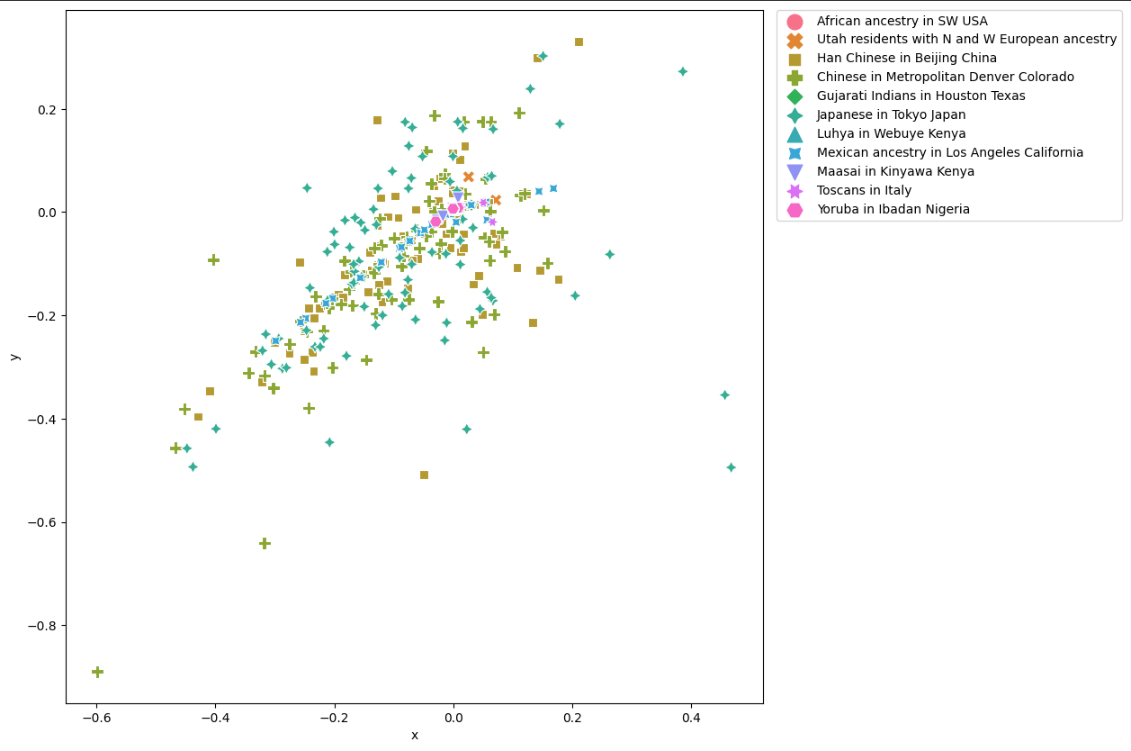![L2-3.PNG](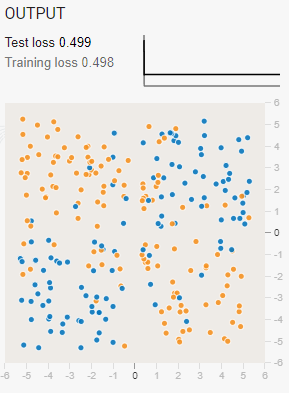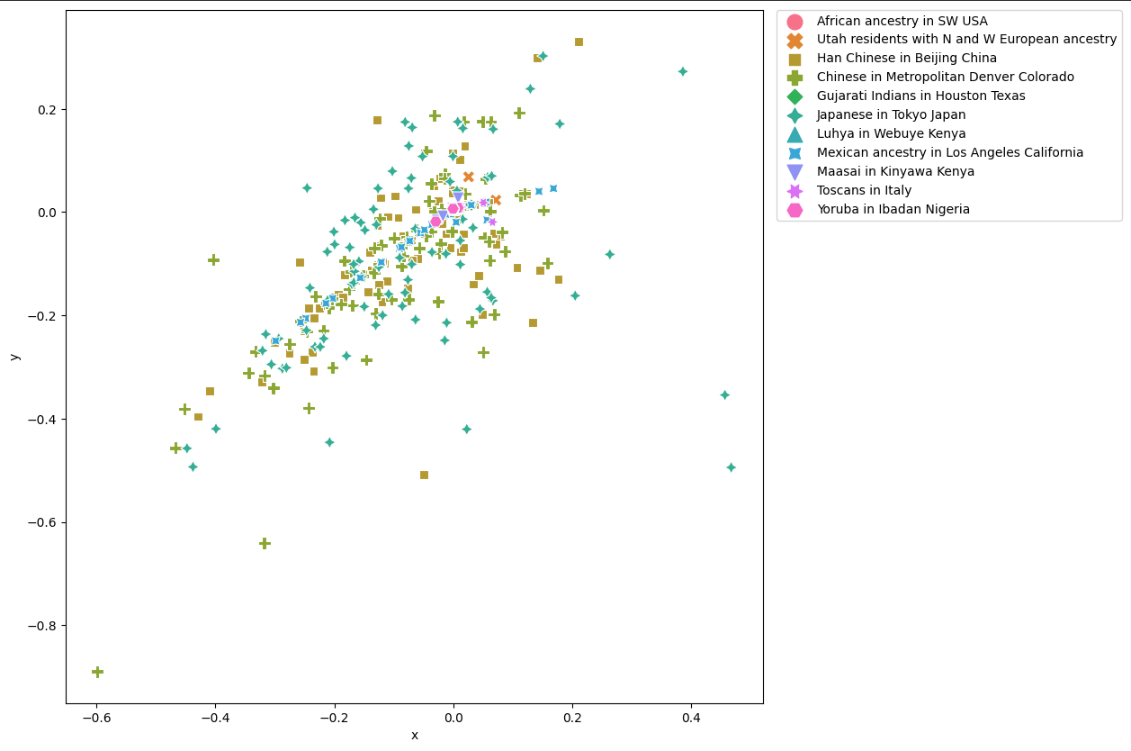))


*   How many individuals are in the dataset
*   How many individuals per population
*   Do we have the same number of males and females
*   How many full- and half-siblings do we have in the dataset
*   How many families do we have


In [ ]:
# Number of individuals in the dataset
print("Number of individuals:", len(pheno))


# Individuals per population
ind_pop = pheno['population'].value_counts()

print("\nIndividuals per population:")
print(ind_pop.to_string())


# How many full- and half-siblings do we have in the dataset
full_siblings_count = 0
half_siblings_count = 0

for individual in pheno['id']:
    dad = pheno.loc[individual, 'dad']
    mom = pheno.loc[individual, 'mom']

    if dad != 0 and mom != 0:

      # Full siblings share one parent
      if (pheno[(pheno['dad'] == dad) & (pheno['mom'] == mom) & (pheno['id'] != individual)].any() != 0).any():
          full_siblings_count += 1

      # Half siblings share one parent
      if (pheno[(pheno['dad'] == dad) | (pheno['mom'] == mom) & (pheno['id'] != individual)].any() != 0).any():
          half_siblings_count += 1

print(f'\nFull siblings: {full_siblings_count}\nHalf siblings: {half_siblings_count}')


# Number of males and females
male = 0
female = 0
for value in pheno['sex']:
  if value == 1:
    male += 1
  else:
    female += 1

print(f'\nMales: {male}\nFemales: {female}')

# How many families do we have
# Combine 'dad' and 'mom' columns to represent families
pheno['Family'] = pheno['dad'].astype(str) + '_' + pheno['mom'].astype(str)

# Count the number of unique families
num_families = pheno['Family'].nunique()

print(f"\nNumber of Families: {num_families}")

Number of individuals: 1184

Individuals per population:
MKK    171
YRI    167
CEU    165
LWK     90
GIH     88
TSI     88
JPT     86
CHD     85
CHB     84
ASW     83
MEX     77

Full siblings: 988
Half siblings: 1184

Males: 589
Females: 595

Number of Families: 197


Now, we will create a dictionary and re-name our populations so that the names are a bit more informative:

In [ ]:
pop_dict = {'ASW':'African ancestry in SW USA',
            'CEU':'Utah residents with N and W European ancestry',
            'CHB':'Han Chinese in Beijing China',
            'CHD':'Chinese in Metropolitan Denver Colorado',
            'GIH':'Gujarati Indians in Houston Texas',
            'JPT':'Japanese in Tokyo Japan',
            'LWK':'Luhya in Webuye Kenya',
            'MEX':'Mexican ancestry in Los Angeles California',
            'MKK':'Maasai in Kinyawa Kenya',
            'TSI':'Toscans in Italy',
            'YRI':'Yoruba in Ibadan Nigeria'}
pheno2 = pheno.replace({"population": pop_dict})
pheno2

,id,sex,FID,dad,mom,pheno,population,Family
NA19919,NA19919,1,2427,NA19908,NA19909,0,African ancestry in SW USA,NA19908_NA19909
NA19916,NA19916,1,2431,0,0,0,African ancestry in SW USA,0_0
NA19835,NA19835,0,2424,0,0,0,African ancestry in SW USA,0_0
NA20282,NA20282,0,2469,0,0,0,African ancestry in SW USA,0_0
NA19703,NA19703,1,2368,0,0,0,African ancestry in SW USA,0_0
...,...,...,...,...,...,...,...,...
NA19119,NA19119,1,Y060,0,0,0,Yoruba in Ibadan Nigeria,0_0
NA18860,NA18860,1,Y012,NA18859,NA18858,0,Yoruba in Ibadan Nigeria,NA18859_NA18858
NA19207,NA19207,1,Y051,0,0,0,Yoruba in Ibadan Nigeria,0_0
NA19103,NA19103,1,Y042,NA19101,NA19102,0,Yoruba in Ibadan Nigeria,NA19101_NA19102


In [ ]:
# TASK Scaling
# We need to scale our counts data so that it is bound between 0 and 1.

# Simply done by dividingg by the largest number
# Now we get 0, 0.5, and 1
geno_data = data / 2
print(geno_data)

         rs416967  rs17013842  rs13052452  rs11049986  rs10994341  rs1504289  \
NA19919       1.0         0.5         0.0         0.5         0.5        0.0   
NA19916       0.5         0.0         0.0         0.5         0.5        0.0   
NA19835       0.0         0.0         0.5         0.5         0.0        0.5   
NA20282       0.5         0.5         0.0         0.5         0.0        0.0   
NA19703       0.0         0.0         0.0         0.0         0.5        0.5   
...           ...         ...         ...         ...         ...        ...   
NA19119       0.5         0.0         0.5         0.0         0.5        0.5   
NA18860       0.5         0.0         0.0         0.5         0.5        0.0   
NA19207       1.0         0.0         0.0         0.0         0.5        0.0   
NA19103       0.5         0.0         0.5         0.0         0.0        0.0   
NA19099       0.0         0.0         0.5         0.5         0.0        0.5   

         rs882529  rs3885937  rs537330 

In [ ]:
# TASK Randomly split into the training and the validation set, so that 80 per-cent of individuals ends up in the training set.

train = geno_data.sample(frac = 0.8, random_state = 42)
test = geno_data.drop(train.index)
train.reset_index()
test.reset_index()

# TASK Print some info about the resulting split
print("Total number of individuals:", len(geno_data))
print("\t - training set:", len(train))
print("\t - test set:", len(test))

Total number of individuals: 1184
	 - training set: 947
	 - test set: 237


<class 'numpy.ndarray'>
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5000)]            0         
                                                                 
 layer1 (Dense)              (None, 1500)              7501500   
                                                                 
 batch_normalization (Batch  (None, 1500)              6000      
 Normalization)                                                  
                                                                 
 layer3 (Dropout)            (None, 1500)              0         
                                                                 
 layer4 (Dense)              (None, 250)               375250    
                                                                 
 layer5 (Dropout)            (None, 250)               0         
                                     

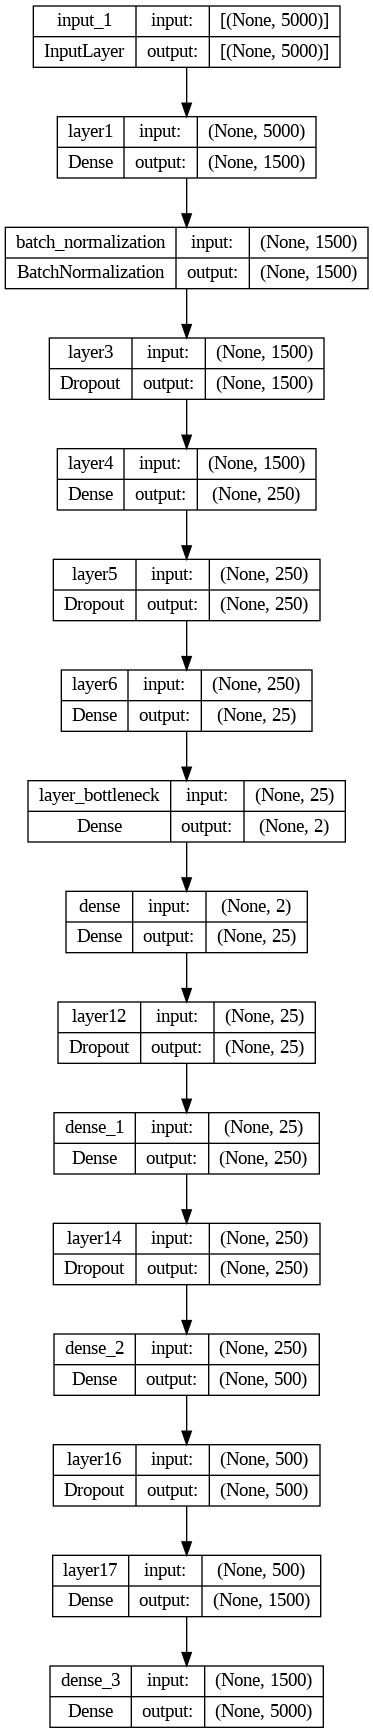

In [ ]:

train_tensor = train.to_numpy()
print(type(train_tensor))


# use ReLu activations, ADAM optimizer and
# mean squared error as the loss function
hp_loss_fn = 'mse'
hp_act_fn = 'relu'
hp_optimizer = keras.optimizers.Adam(learning_rate=0.001)
hp_metrics = ['mse','mae','mape']

input_data = keras.Input(shape = train_tensor.shape[1])

# Define architecture of the encoder:
# the second layer should be a batch normalization
"""
# Encoder
c1 = layers.Dense(units = 1500, activation = hp_act_fn, name='layer1')(input_data)
x = layers.BatchNormalization()(c1)
x = layers.Dropout(rate = 0.05, name='layer3')(x)
x = layers.Dense(units = 250, activation = hp_act_fn, name='layer4')(x)
x = layers.Dropout(rate = 0.025, name='layer5')(x)
c2 = layers.Dense(units = 25, activation = hp_act_fn, name='layer6')(x)
bottleneck = layers.Dense(units = 2, name='layer_bottleneck')(c2)

# Decoder
x = layers.Dense(units = 25, activation = hp_act_fn)(bottleneck)
x = layers.Add()([c2, x])
x = layers.Dropout(rate=0.025, name='layer12')(x)
x = layers.Dense(units = 250, activation = hp_act_fn)(x)
x = layers.Dropout(rate=0.05, name='layer14')(x)
x = layers.Dense(units = 500, activation = hp_act_fn)(x)
x = layers.Dropout(rate=0.1, name='layer16')(x)
x = layers.Dense(units=1500, activation=hp_act_fn, name='layer11')(x)
x = layers.Add()([c1, x])
decoded = layers.Dense(units = train_tensor.shape[1], activation = 'sigmoid')(x)

autoencoder_model = keras.Model(inputs = input_data, outputs = decoded)
autoencoder_model.compile(
  loss = hp_loss_fn,
  optimizer = hp_optimizer,
  metrics = hp_metrics
)

"""
def Encoder(input):
  # Encoder
  layer1 = layers.Dense(units = 1500, activation = hp_act_fn, name='layer1')(input)
  layer2 = layers.BatchNormalization()(layer1)
  layer3 = layers.Dropout(rate = 0.05, name='layer3')(layer2)
  layer4 = layers.Dense(units = 250, activation = hp_act_fn, name='layer4')(layer3)
  layer5 = layers.Dropout(rate = 0.025, name='layer5')(layer4)
  layer6 = layers.Dense(units = 25, activation = hp_act_fn, name='layer6')(layer5)
  bottleneck = layers.Dense(units = 2, name='layer_bottleneck')(layer6)
  return(bottleneck)

def Decoder(bottleneck):
  # Decoder
  layer7 = layers.Dense(units = 25, activation = hp_act_fn)(bottleneck)
  layer8 = layers.Dropout(rate=0.025, name='layer12')(layer7)
  layer9 = layers.Dense(units = 250, activation = hp_act_fn)(layer8)
  layer10 = layers.Dropout(rate=0.05, name='layer14')(layer9)
  layer11 = layers.Dense(units = 500, activation = hp_act_fn)(layer10)
  layer12 = layers.Dropout(rate=0.1, name='layer16')(layer11)
  layer13 = layers.Dense(units=1500, activation=hp_act_fn, name='layer17')(layer12)
  layer14 = layers.Dense(units = train_tensor.shape[1], activation = 'sigmoid')(layer13)
  return(layer14)

def Autoencoder(input):
  enc = Encoder(input)
  autoenc = Decoder(enc)
  return(autoenc)

autoencoder_model = keras.Model(inputs = input_data, outputs = Autoencoder(input_data))
autoencoder_model.compile(
  loss = hp_loss_fn,
  optimizer = hp_optimizer,
  metrics = hp_metrics
)

# TASK Visualise the created architecture and summarise its parameters
autoencoder_model.summary()
keras.utils.plot_model(autoencoder_model, "autoencoder_model.png", show_shapes=True)

In [ ]:
# TASK Set hyperparameters for model fitting
# Begin by training for 30 epochs, with mini-batch of 256 and validation set
# having 20 per-cent of examples

hp_epochs = 30
hp_batch_size = 256
hp_val_split = 0.2

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

autoencoder = autoencoder_model.fit(x = train_tensor,
                      y = train_tensor,
                      epochs = hp_epochs,
                      batch_size = hp_batch_size,
                      shuffle = True,
                      validation_split = hp_val_split,
                      )

Epoch 1/30
3/3 [==============================] - 5s 783ms/step - loss: 0.1841 - mse: 0.1841 - mae: 0.3701 - mape: 340200480.0000 - val_loss: 0.1820 - val_mse: 0.1820 - val_mae: 0.3676 - val_mape: 337898656.0000
Epoch 2/30
3/3 [==============================] - 2s 635ms/step - loss: 0.1540 - mse: 0.1540 - mae: 0.3435 - mape: 300177568.0000 - val_loss: 0.1249 - val_mse: 0.1249 - val_mae: 0.3166 - val_mape: 261259072.0000
Epoch 3/30
3/3 [==============================] - 2s 629ms/step - loss: 0.0853 - mse: 0.0853 - mae: 0.2007 - mape: 77929488.0000 - val_loss: 0.0722 - val_mse: 0.0722 - val_mae: 0.1893 - val_mape: 90361512.0000
Epoch 4/30
3/3 [==============================] - 2s 895ms/step - loss: 0.0828 - mse: 0.0828 - mae: 0.1653 - mape: 46478312.0000 - val_loss: 0.0744 - val_mse: 0.0744 - val_mae: 0.1783 - val_mape: 85993304.0000
Epoch 5/30
3/3 [==============================] - 3s 1s/step - loss: 0.0772 - mse: 0.0772 - mae: 0.1702 - mape: 61674544.0000 - val_loss: 0.0725 - val_mse: 

Now, let us look at the training process:

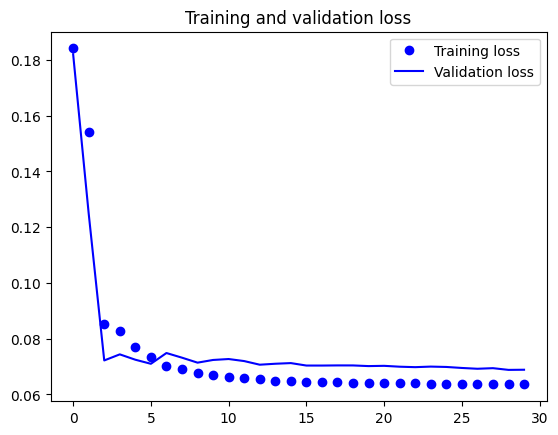

In [ ]:
loss = autoencoder.history['loss']
val_loss = autoencoder.history['val_loss']
epochs = range(hp_epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Now, that the model is trained, we can save the weights and use them to build an encoder. Note that weights are saved for the entire autoencoder, so we need to use `skip_mismatch = True` along with `by_name = True` to initialize weights in our encoder.

In [ ]:
autoencoder_model.save_weights('autoencoder_weights.h5',
                               overwrite = True)

encoder_model = keras.Model(inputs = input_data, outputs = Encoder(input_data))
encoder_model.load_weights('autoencoder_weights.h5',
                           skip_mismatch = True,
                           by_name = True)
encoder_model.compile(
  loss = hp_loss_fn,
  optimizer = hp_optimizer,
  metrics = hp_metrics,
)


Let us embed our genotyping data using the encoder we have just constructed.
We can also visualise the embedding.

37/37 [==============================] - 1s 19ms/step
[[8.46085   5.094903 ]
 [7.67389   5.191395 ]
 [8.421238  5.17507  ]
 ...
 [8.081809  6.3446455]
 [8.927946  6.5604835]
 [8.792965  6.577123 ]]


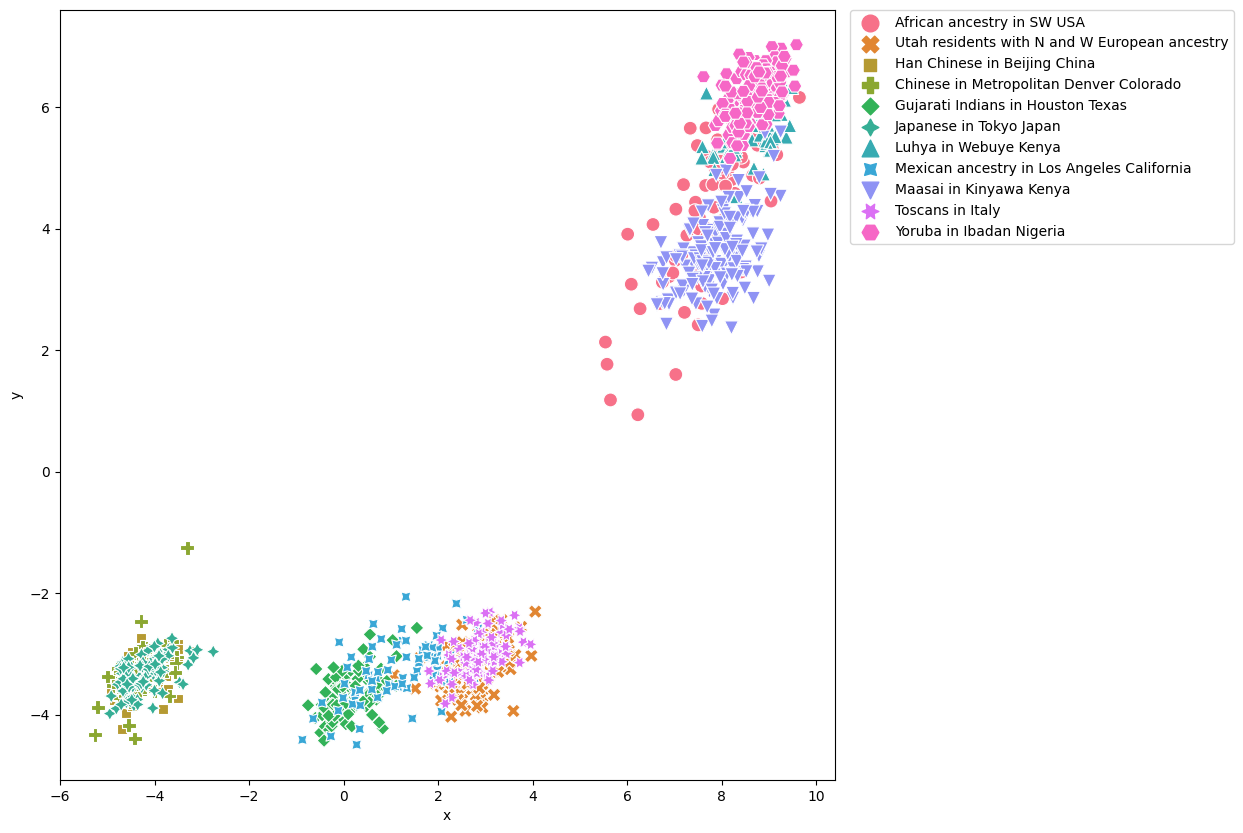

In [ ]:
embeded_points = encoder_model.predict(geno_data.to_numpy())
print(embeded_points)

x = embeded_points[:,0]
y = embeded_points[:,1]
pop = pheno2['population']
data = {'x':x, 'y':y, 'pop':pop}
plt.figure(figsize = (10,10))
sns.scatterplot(x='x', y='y', data=data, hue='pop', style='pop', s=100)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, markerscale=2)
plt.show()

Now, we will compare the result with:
* MDS on the kinship matrix
* PCA perfored directly on raw genotypes


In [ ]:
kinship = pd.read_csv("autosomal_5k_kinship.csv", header=0, index_col=0)


In [ ]:
from sklearn.manifold import MDS
embedding = MDS(n_components=2)
mds_embedding = embedding.fit_transform(kinship)


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


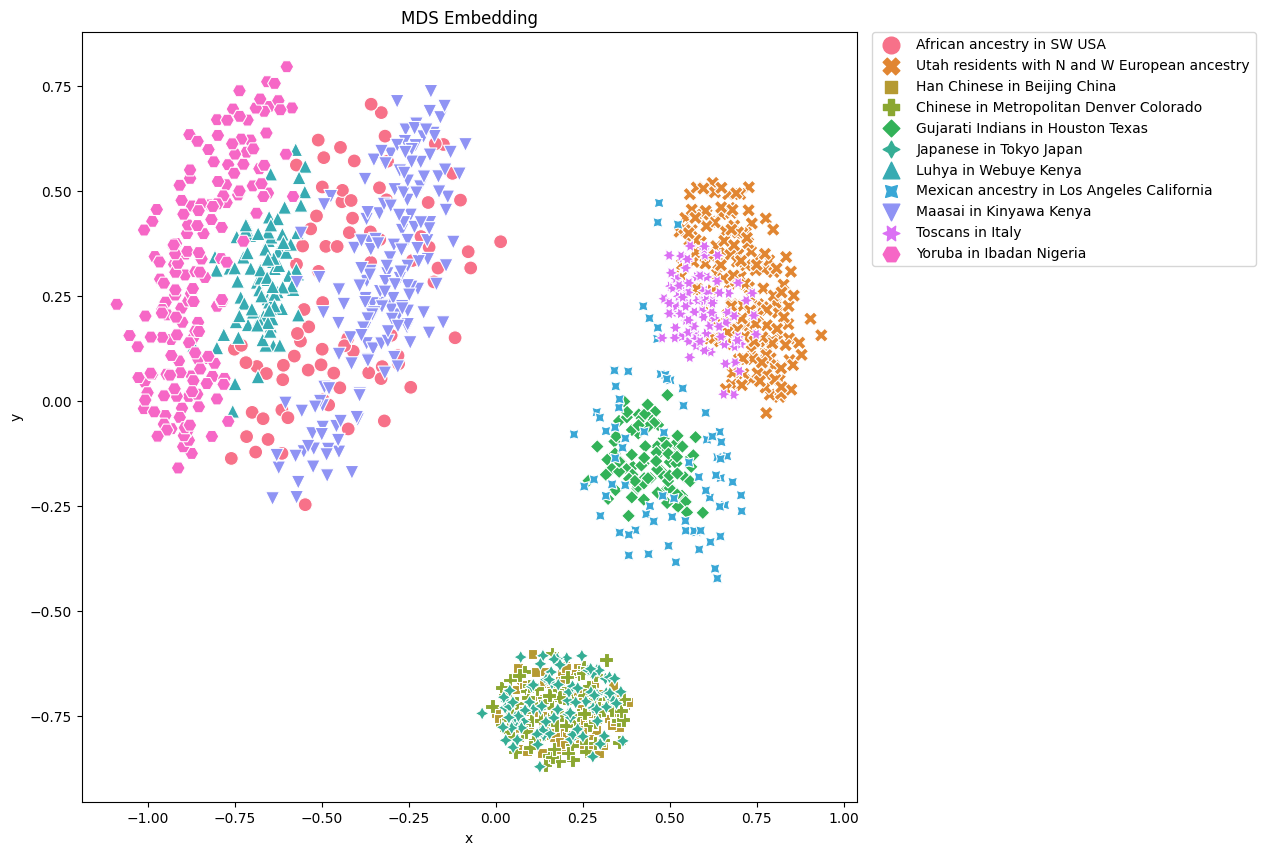

In [ ]:
# TASK Plot MDS embedding in a way similar to plotting autoencoder embeddings
x = mds_embedding[:, 0]
y = mds_embedding[:, 1]
data = {'x':x, 'y':y, 'pop':pop}
plt.figure(figsize = (10,10))
# Plot MDS embedding similar to autoencoder embeddings
sns.scatterplot(x='x', y='y', data=data, hue='pop', style='pop', s=100)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, markerscale=2)
plt.title('MDS Embedding')
plt.show()

Finally, we will perform PCA on raw genotypes:

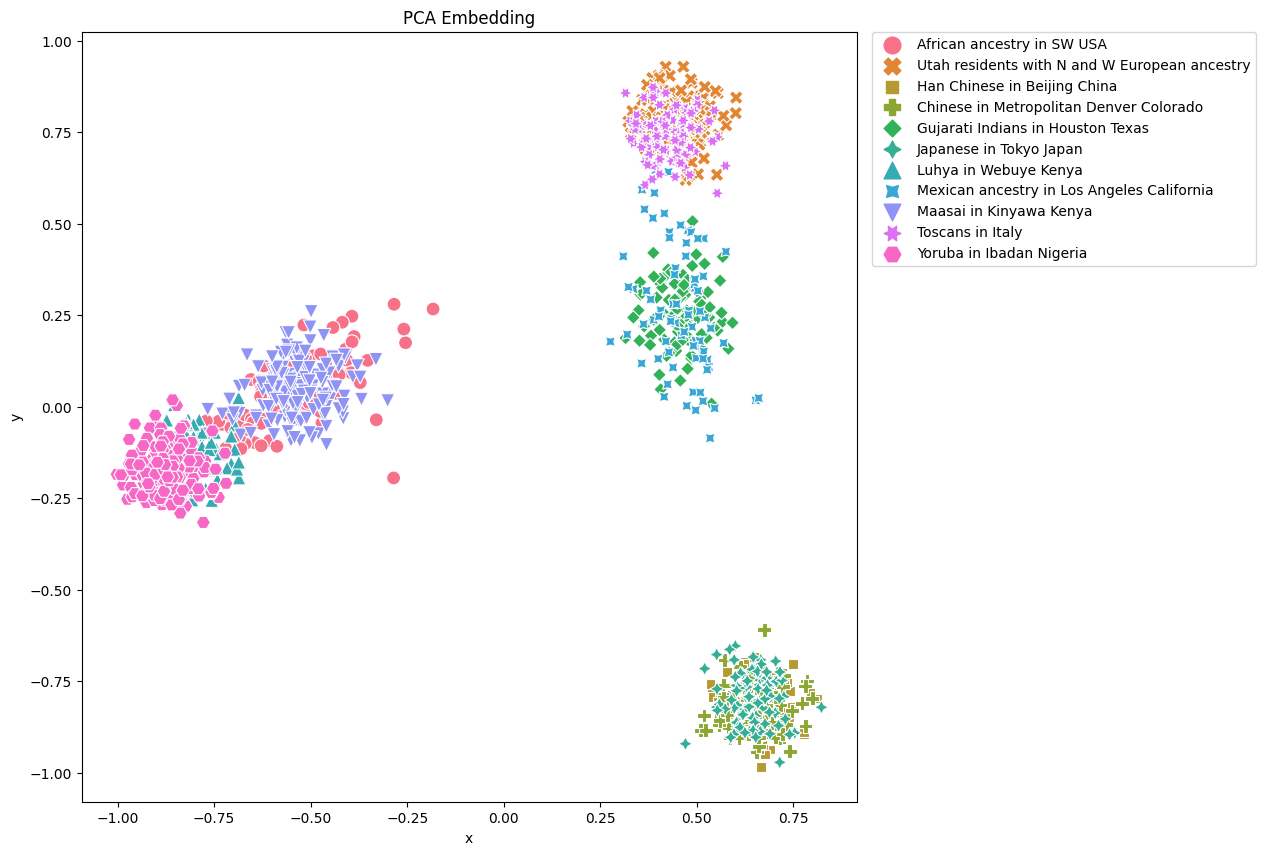

In [ ]:
# TASK perform PCA with 2 components on raw genotypes (use geno_data as input but remember it has been scaled)
# Visualise the result.
from sklearn.decomposition import PCA
embedding = PCA(n_components=2)
pca_embedding = embedding.fit_transform(geno_data/5)

# Extract x and y coordinates
x = -pca_embedding[:, 0]
y = -pca_embedding[:, 1]

pop = pheno2['population']


# Create a DataFrame for plotting
data = {'x': x, 'y': y, 'pop': pop}
plt.figure(figsize=(10, 10))

# Plot PCA embedding
sns.scatterplot(x='x', y='y', data=data, hue='pop', style='pop', s=100)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, markerscale=2)
plt.title('PCA Embedding')
plt.show()

# Comparison

The most obvious differences between the three is that PCA seams to be more "precise" and doesn't show a large spread of the populations whereas both MDS and Autoencoder embedding show that the populations cover a larger area (*The Autoencoder did cover a larger area, higher variance, however when I  tried to replicate my first result I couldn't get it back*).

We can also observe that the Autoencoder was able to differentiate between *Gujarati Indians in Houston Texas* and *Mexican ancestry in Los Angeles California* whereas both MDS and PCA "classified" them as the same population. However, it is worth noting that the Autoencoder had a high variance in the result of *Mexican ancestry in Los Angeles California*.

From just taking a quick glance at the plots the Autoencoder resembles the MDS more than the PCA.

 -

# Modifying the Autoencoder

**Architecture 1:**

Encoder:
*   Dense - 1000
*   Dense - 500
*   Dense - 50
*   Bottleneck(Dense) - 2

Decoder:
*   Dense - 50
*   Dense - 500
*   Dense - 1000
*   Output(Dense) - 1

Activation: ReLU
Epochs: 50
Batch size: 512

This gave a result with lower variance for each populations. However, they get bunched up into 3 piles where it's impossible to differentiate between the populations in that pile. MDS and PCA gives us 4-6 piles with different populations

**Shortcuts**

Introducing shortcuts looked promising in the begining during the training phase as the training nad validation loss kept going lower than with previous architectures. However, the result was very poor with no way to distinguish between any population (see image attatched in the submition).


